In [1]:
import os
import datetime
import pickle
import math

import scipy
import numpy  as np
import pandas as pd
import cv2

from matplotlib   import pyplot     as plt
from keras.models import load_model
from keras.models import model_from_json
from PIL          import Image

from sklearn.metrics       import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.neighbors     import NearestNeighbors

import boto3
import zipfile

import attribute_utils
import dataset_utils
import prediction_utils


In [2]:
time_start = datetime.datetime.now()
print(str(time_start))

2021-03-16 01:39:29.901437


In [3]:
#=========================================================================
# https://www.kaggle.com/muhammeddalkran/lfw-simulated-masked-face-dataset
# https://www.kaggle.com/jessicali9530/lfw-dataset
# https://www.kaggle.com/averkij/lfw-attributes
#=========================================================================

In [4]:
SHOW_MODEL = True

S3_BUCKET_NAME = "cs230project"
INPUTS_FNAME   = "lfw_datasets_and_models.zip"

PATH_INPUTS_FNAME     = "../../lfw_datasets_and_models.zip" 
PATH_INPUTS           = "../../lfw_datasets_and_models"

PATH_MODEL_FACENET_PRE = PATH_INPUTS + "/models/facenet/pretrained/model/facenet_keras.h5"

PATH_MODEL_FACENET_RET_ARCH    = PATH_INPUTS + "/models/facenet/retrained/encoding_facenet_arch.json"
PATH_MODEL_FACENET_RET_WEIGHTS = PATH_INPUTS + "/models/facenet/retrained/encoding_facenet_weights.h5"

PATH_MODEL_RESNET_ARCH    = PATH_INPUTS + "/models/resnet/encoding_resnet_arch.json"
PATH_MODEL_RESNET_WEIGHTS = PATH_INPUTS + "/models/resnet/encoding_resnet_weights.h5"

PATH_DATASET_BASE     = PATH_INPUTS + "/datasets/"

PATH_DATASET_BASE_MASKED   = PATH_DATASET_BASE + "/masked"
PATH_DATASET_BASE_UNMASKED = PATH_DATASET_BASE + "/unmasked"

PATH_DATASET_MASKED_TRAIN = PATH_DATASET_BASE_MASKED + "/train/"
PATH_DATASET_MASKED_VAL   = PATH_DATASET_BASE_MASKED + "/validation/"
PATH_DATASET_MASKED_TEST  = PATH_DATASET_BASE_MASKED + "/test/"

PATH_DATASET_UNMASKED_TRAIN = PATH_DATASET_BASE_UNMASKED + "/train/"
PATH_DATASET_UNMASKED_VAL   = PATH_DATASET_BASE_UNMASKED + "/validation/"
PATH_DATASET_UNMASKED_TEST  = PATH_DATASET_BASE_UNMASKED + "/test/"

PATH_DATASET_ATTRIBUTES = PATH_DATASET_BASE + "/attributes/lfw_attributes.csv"

PREDICT_THRESHOLD = 0.78125

MODEL = "facenet-pretrained"
# MODEL = "facenet-retrained"
# MODEL = "resnet"

# REQUIRED_SIZE = (224, 224)
REQUIRED_SIZE = (160, 160)


In [5]:
"""
Given a FaceNet model and an image
"""
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]

In [6]:
"""
Returns the cosine distance between two vectors.
"""
def cosine_distance(a: np.ndarray, b: np.ndarray) -> float:
    return scipy.spatial.distance.cosine(a, b)

In [7]:
def show_image(dataset_name: str, filename: str):
    img = dataset_utils.extract_face(dataset_name + filename)
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    print(img.shape)

In [8]:
def get_embeddings(dataset, facenet_model):
    ret = list()
    i = 0
    for face in dataset:
        emd = get_embedding(facenet_model, face)
        ret.append(emd)
        if (i % 1000 == 0):
            print(i)
        i += 1
    ret = np.asarray(ret)
    return ret

In [9]:
dataset_utils.download_s3_file(S3_BUCKET_NAME, INPUTS_FNAME, PATH_INPUTS_FNAME)

[INFO] '../../lfw_datasets_and_models.zip' exists.


In [10]:
dataset_utils.extract_zipfile(PATH_INPUTS_FNAME, PATH_INPUTS, "../../")

[INFO] Directory '../../lfw_datasets_and_models' exists.


In [11]:
print("[INFO] Loading attributes...", end=" ")
df_attributes = pd.read_csv(PATH_DATASET_ATTRIBUTES, sep=",", header=0)
df_attributes = df_attributes[(df_attributes.person != "Larry Coker")]
print("DONE.")

print("[INFO] Setting attribute 'Gender'...", end=" ")
df_attributes = attribute_utils.fix_attribute_gender(df_attributes)
print("DONE.")

print("[INFO] Setting attribute 'Race'...", end=" ")
df_attributes = attribute_utils.fix_attribute_race(df_attributes)
print("DONE.")

print("[INFO] Setting attribute 'Age'...", end=" ")
df_attributes = attribute_utils.fix_attribute_age(df_attributes)
print("DONE.")

[INFO] Loading attributes... DONE.
[INFO] Setting attribute 'Gender'... DONE.
[INFO] Setting attribute 'Race'... DONE.
[INFO] Setting attribute 'Age'... DONE.


In [12]:
plt.rc("font", size=14)
plt.rc("axes", titlesize=24)

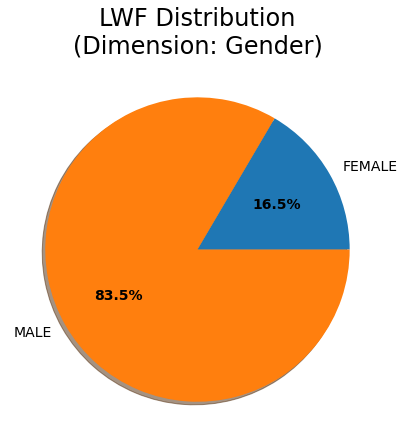

In [14]:
df_genders = df_attributes[["Gender"]].groupby(["Gender"]).size().reset_index(name = "count")

labels     = df_genders["Gender"]
values     = df_genders["count"]

fig, ax                  = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(values, labels=labels, autopct="%1.1f%%", shadow=True)
ax.set_title("LWF Distribution\n(Dimension: Gender)")

plt.setp(autotexts, size=14, weight="bold")

plt.savefig("../analysis/lfw_gender.jpg")
plt.show()


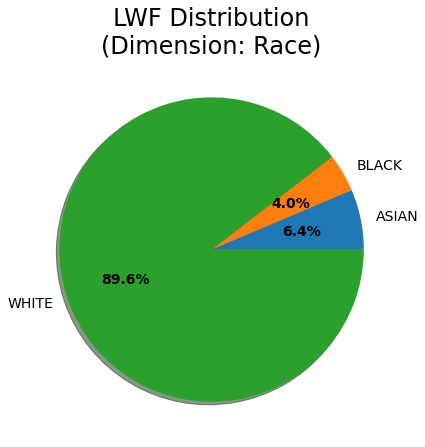

In [15]:
df_races = df_attributes[["Race"]].groupby(["Race"]).size().reset_index(name = "count")

labels     = df_races["Race"]
values     = df_races["count"]

fig, ax                  = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(values, labels=labels, autopct="%1.1f%%", shadow=True)

plt.setp(autotexts, size=14, weight="bold")
ax.set_title("LWF Distribution\n(Dimension: Race)")

plt.setp(autotexts, size=14, weight="bold")

plt.savefig("../analysis/lfw_race.jpg")
plt.show()

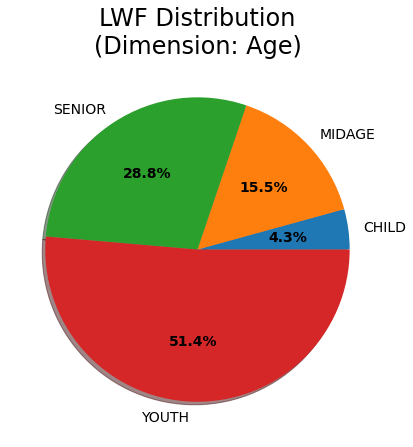

In [16]:
df_ages = df_attributes[["Age"]].groupby(["Age"]).size().reset_index(name = "count")

labels     = df_ages["Age"]
values     = df_ages["count"]

fig, ax                  = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(values, labels=labels, autopct="%1.1f%%", shadow=True)

ax.set_title("LWF Distribution\n(Dimension: Age)")

plt.setp(autotexts, size=14, weight="bold")

plt.savefig("../analysis/lfw_age.jpg")
plt.show()

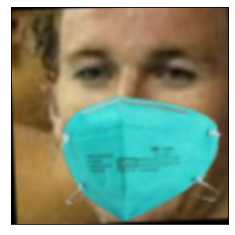

(160, 160, 3)


In [17]:
show_image(PATH_DATASET_MASKED_TEST, "/Aaron_Peirsol/Aaron_Peirsol_0004.jpg")

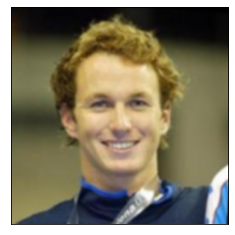

(160, 160, 3)


In [18]:
show_image(PATH_DATASET_UNMASKED_VAL, "/Aaron_Peirsol/Aaron_Peirsol_0003.jpg")

In [19]:
print("[INFO] Loading masked training dataset...")
train_masked_x, train_masked_y = dataset_utils.load_dataset(PATH_DATASET_MASKED_TRAIN, REQUIRED_SIZE)
print(train_masked_x.shape, train_masked_y.shape)

[INFO] Loading masked training dataset...
[DEBUG] Loading dataset... ../../lfw_datasets_and_models/datasets//masked/train/
i=0; subdir=Carl_Levin
i=500; subdir=Craig_Morgan
i=1000; subdir=Lawrence_Vito
i=1500; subdir=Mary_Katherine_Smart
i=2000; subdir=Bryan_Chui
i=2500; subdir=Luis_Gonzalez
i=3000; subdir=Ian_Wilmut
i=3500; subdir=Melvin_Talbert
i=4000; subdir=Ben_Kingsley
i=4500; subdir=Claudia_Pechstein
i=5000; subdir=Charmaine_Crooks
i=5500; subdir=Roberto_Laratro
(10559, 160, 160, 3) (10559,)


In [20]:
print("[INFO] Loading unmasked training dataset...")
train_unmasked_x, train_unmasked_y = dataset_utils.load_dataset(PATH_DATASET_UNMASKED_TRAIN, REQUIRED_SIZE)
print(train_unmasked_x.shape, train_unmasked_y.shape)

[INFO] Loading unmasked training dataset...
[DEBUG] Loading dataset... ../../lfw_datasets_and_models/datasets//unmasked/train/
i=0; subdir=Carl_Levin
i=500; subdir=Aleksander_Kwasniewski
i=1000; subdir=Asif_Ali_Zardari
i=1500; subdir=Robin_McLaurin_Williams
i=2000; subdir=Thanongsak_Tuvinan
i=2500; subdir=Gregory_Peck
i=3000; subdir=Roger_King
i=3500; subdir=Helio_Castroneves
i=4000; subdir=Luther_Htu
i=4500; subdir=Joaquin_Sanchez
i=5000; subdir=Jong_Thae_Hwa
i=5500; subdir=Sean_OKeefe
(11429, 160, 160, 3) (11429,)


In [21]:
print("[INFO] Loading masked validation dataset...")
val_masked_x, val_masked_y = dataset_utils.load_dataset(PATH_DATASET_MASKED_VAL, REQUIRED_SIZE)
print(val_masked_x.shape, val_masked_y.shape)

[INFO] Loading masked validation dataset...
[DEBUG] Loading dataset... ../../lfw_datasets_and_models/datasets//masked/validation/
i=0; subdir=Mohamed_ElBaradei
i=500; subdir=Torri_Edwards
i=1000; subdir=Tamara_Brooks
i=1500; subdir=Jean_Chretien
(1664, 160, 160, 3) (1664,)


In [22]:
print("[INFO] Loading unmasked validation dataset...")
val_unmasked_x, val_unmasked_y = dataset_utils.load_dataset(PATH_DATASET_UNMASKED_VAL, REQUIRED_SIZE)
print(val_unmasked_x.shape, val_unmasked_y.shape)

[INFO] Loading unmasked validation dataset...
[DEBUG] Loading dataset... ../../lfw_datasets_and_models/datasets//unmasked/validation/
i=0; subdir=Mohamed_ElBaradei
i=500; subdir=Andrew_Cuomo
i=1000; subdir=Miroljub
i=1500; subdir=Michael_J_Sheehan
(1679, 160, 160, 3) (1679,)


In [23]:
print("[INFO] Loading masked test dataset...")
test_masked_x, test_masked_y = dataset_utils.load_dataset(PATH_DATASET_MASKED_TEST, REQUIRED_SIZE)
print(test_masked_x.shape, test_masked_y.shape)

[INFO] Loading masked test dataset...
[DEBUG] Loading dataset... ../../lfw_datasets_and_models/datasets//masked/test/
i=0; subdir=Mohamed_ElBaradei
i=500; subdir=Ana_Palacio
(887, 160, 160, 3) (887,)


In [24]:
print("[INFO] Loading unmasked test dataset...")
test_unmasked_x, test_unmasked_y = dataset_utils.load_dataset(PATH_DATASET_UNMASKED_TEST, REQUIRED_SIZE)
print(test_unmasked_x.shape, test_unmasked_y.shape)

[INFO] Loading unmasked test dataset...
[DEBUG] Loading dataset... ../../lfw_datasets_and_models/datasets//unmasked/test/
i=0; subdir=Mohamed_ElBaradei
i=500; subdir=Christopher_Reeve
(900, 160, 160, 3) (900,)


In [25]:
# combine masked and unmasked datasets
train_x = np.concatenate((train_masked_x, train_unmasked_x), axis=0)
train_y = np.concatenate((train_masked_y, train_unmasked_y), axis=0)

val_x = np.concatenate((val_masked_x, val_unmasked_x), axis=0)
val_y = np.concatenate((val_masked_y, val_unmasked_y), axis=0)

test_x = np.concatenate((test_masked_x, test_unmasked_x), axis=0)
test_y = np.concatenate((test_masked_y, test_unmasked_y), axis=0)

print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)
print(test_x.shape, test_y.shape)

(21988, 160, 160, 3) (21988,)
(3343, 160, 160, 3) (3343,)
(1787, 160, 160, 3) (1787,)


In [26]:
total_masked   = train_masked_x.shape[0]   + val_masked_x.shape[0]   + test_masked_x.shape[0]
total_unmasked = train_unmasked_x.shape[0] + val_unmasked_x.shape[0] + test_unmasked_x.shape[0]

total = total_masked + total_unmasked

print("Masked split:   [train / val / test] = [%d / %d / %d]" % (train_masked_x.shape[0], val_masked_x.shape[0], test_masked_x.shape[0]))
print("UnMasked split: [train / val / test] = [%d / %d / %d]" % (train_unmasked_x.shape[0], val_unmasked_x.shape[0], test_unmasked_x.shape[0]))
print("Total split:    [train / val / test] = [%d / %d / %d]" % (train_x.shape[0], val_x.shape[0], test_x.shape[0]))

print("")

print("Masked split:   [train / val / test] = [%4.2f%% / %4.2f%% / %4.2f%%]" % (
    train_masked_x.shape[0] / total_masked * 100,
    val_masked_x.shape[0]   / total_masked * 100,
    test_masked_x.shape[0]  / total_masked * 100))

print("Unmasked split: [train / val / test] = [%4.2f%% / %4.2f%% / %4.2f%%]" % (
    train_unmasked_x.shape[0] / total_unmasked * 100,
    val_unmasked_x.shape[0]   / total_unmasked * 100,
    test_unmasked_x.shape[0]  / total_unmasked * 100))

print("Total split:    [train / val / test] = [%4.2f%% / %4.2f%% / %4.2f%%]" % (
    train_x.shape[0] / total * 100,
    val_x.shape[0]   / total * 100,
    test_x.shape[0]  / total * 100))


Masked split:   [train / val / test] = [10559 / 1664 / 887]
UnMasked split: [train / val / test] = [11429 / 1679 / 900]
Total split:    [train / val / test] = [21988 / 3343 / 1787]

Masked split:   [train / val / test] = [80.54% / 12.69% / 6.77%]
Unmasked split: [train / val / test] = [81.59% / 11.99% / 6.42%]
Total split:    [train / val / test] = [81.08% / 12.33% / 6.59%]


In [27]:
def load_model_arch_weights(path_model_arch, path_model_weights):
    with open(path_model_arch, "r") as json_file:
        model_arch = json_file.read()

    #load the model architecture 
    model = model_from_json(model_arch)

    #load the model weights
    model.load_weights(path_model_weights)

    return model

In [28]:
def load_model_():
    ret = None
    if (MODEL == "facenet-pretrained"):
        print("[INFO] Loading Facenet pre-trained model...", PATH_MODEL_FACENET_PRE)
        ret = load_model(PATH_MODEL_FACENET_PRE)
        print('[INFO] Loaded Model')
    elif (MODEL == "facenet-retrained"):
        ret = load_model_arch_weights(PATH_MODEL_FACENET_RET_ARCH, PATH_MODEL_FACENET_RET_WEIGHTS)
    elif (MODEL == "resnet"):
        ret = load_model_arch_weights(PATH_MODEL_RESNET_ARCH, PATH_MODEL_RESNET_WEIGHTS)

    if (SHOW_MODEL):
        ret.summary()

    return ret

In [29]:
facenet_model = load_model_()

[INFO] Loading Facenet pre-trained model... ../../lfw_datasets_and_models/models/facenet/pretrained/model/facenet_keras.h5
[INFO] Loaded Model
Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (Non

In [30]:
print("[INFO] Generating embeddings for training set...", end=" ")
train_emd_x = get_embeddings(train_x, facenet_model)
print("DONE.")
print(train_emd_x.shape)

[INFO] Generating embeddings for training set... 0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
DONE.
(21988, 128)


In [31]:
print("[INFO] Generating embeddings for validation set...", end=" ")
val_emd_x = get_embeddings(val_x, facenet_model)
print("DONE.")
print(val_emd_x.shape)

[INFO] Generating embeddings for validation set... 0
1000
2000
3000
DONE.
(3343, 128)


In [32]:
print("[INFO] Generating embeddings for test set...", end=" ")
test_emd_x = get_embeddings(test_x, facenet_model)
print("DONE.")
print(test_emd_x.shape)

[INFO] Generating embeddings for test set... 0
1000
DONE.
(1787, 128)


In [33]:
print("[INFO] Label encoding...")
print("Dataset: train=%d, test=%d" % (train_emd_x.shape[0], test_emd_x.shape[0]))

# normalize input vectors
in_encoder       = Normalizer(norm='l2')
train_emd_norm_x = in_encoder.transform(train_emd_x)
val_emd_norm_x   = in_encoder.transform(val_emd_x)
test_emd_norm_x  = in_encoder.transform(test_emd_x)

# label encode targets
out_encoder = LabelEncoder()
encoder_arr = np.append (train_y, ['Ben_Affleck', 'Ben_Curtis', 'Ben_Howland', 'Benazir_Bhutto', 'Benjamin_Netanyahu', 'Bernard_Landry', 'Bernard_Law', 'Bertie_Ahern'])
out_encoder.fit(encoder_arr)

[INFO] Label encoding...
Dataset: train=21988, test=1787


LabelEncoder()

In [34]:
df_attributes["Person"] = df_attributes.apply(attribute_utils.get_attribute_person, axis=1)
df_attributes["Person"] = out_encoder.transform(df_attributes["Person"])
df_attributes = df_attributes[["Person", "Gender", "Race", "Age"]]
# df_attributes.set_index("Person")
df_attributes

,Person,Gender,Race,Age
0,2,MALE,WHITE,CHILD
1,3,MALE,WHITE,MIDAGE
2,4,MALE,WHITE,MIDAGE
3,5,MALE,WHITE,YOUTH
4,5,MALE,WHITE,YOUTH
...,...,...,...,...
13138,5743,FEMALE,ASIAN,CHILD
13139,5744,MALE,BLACK,MIDAGE
13140,5745,FEMALE,WHITE,SENIOR
13141,5746,MALE,WHITE,SENIOR


In [35]:
print("[INFO] Encoding training set with fitted encoder...")
train_enc_y = out_encoder.transform(train_y)

[INFO] Encoding training set with fitted encoder...


In [36]:
print("[INFO] Encoding validation set with fitted encoder...")
val_enc_y = out_encoder.transform(val_y)

[INFO] Encoding validation set with fitted encoder...


In [37]:
print("[INFO] Encoding test set with fitted encoder...")
test_enc_y = out_encoder.transform(test_y)

[INFO] Encoding test set with fitted encoder...


In [38]:
print("[INFO] Training NN model on training set...", end=" ")
neighbors  = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(train_emd_norm_x)
print("DONE.")

[INFO] Training NN model on training set... DONE.


In [39]:
print("[INFO] Testing model on training set...", end=" ")
result_predict = prediction_utils.predict(neighbors, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x, train_enc_y, train_emd_norm_x, train_enc_y)
print("DONE.")

[INFO] Testing model on training set... DONE.


In [40]:
print("Training set performance:")
prediction_utils.show_metrics(result_predict)

Training set performance:
    total:  21988 (100.00 %)
    TP:     21986 ( 99.99 %)
    FN:         0 (  0.00 %)
    FP:         2 (  0.01 %)
MALE:
    total:  18470 (100.00 %)
    TP:     18468 ( 99.99 %)
    FN:         0 (  0.00 %)
    FP:         2 (  0.01 %)
FEMALE:
    total:   3518 (100.00 %)
    TP:      3518 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)
WHITE:
    total:  19579 (100.00 %)
    TP:     19577 ( 99.99 %)
    FN:         0 (  0.00 %)
    FP:         2 (  0.01 %)
ASIAN:
    total:   1482 (100.00 %)
    TP:      1482 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)
BLACK:
    total:    927 (100.00 %)
    TP:       927 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)


In [41]:
print("[INFO] Testing model on validation set...", end=" ")
result_predict = prediction_utils.predict(neighbors, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x, train_enc_y, val_emd_norm_x, val_enc_y)
print("DONE.")

[INFO] Testing model on validation set... DONE.


In [42]:
print("Validation set performance:")
prediction_utils.show_metrics(result_predict)

Validation set performance:
    total:   3343 (100.00 %)
    TP:      1679 ( 50.22 %)
    FN:       172 (  5.15 %)
    FP:      1492 ( 44.63 %)
MALE:
    total:   2706 (100.00 %)
    TP:      1372 ( 50.70 %)
    FN:       128 (  4.73 %)
    FP:      1206 ( 44.57 %)
FEMALE:
    total:    637 (100.00 %)
    TP:       307 ( 48.19 %)
    FN:        44 (  6.91 %)
    FP:       286 ( 44.90 %)
WHITE:
    total:   3030 (100.00 %)
    TP:      1494 ( 49.31 %)
    FN:       165 (  5.45 %)
    FP:      1371 ( 45.25 %)
ASIAN:
    total:    166 (100.00 %)
    TP:        98 ( 59.04 %)
    FN:         3 (  1.81 %)
    FP:        65 ( 39.16 %)
BLACK:
    total:    147 (100.00 %)
    TP:        87 ( 59.18 %)
    FN:         4 (  2.72 %)
    FP:        56 ( 38.10 %)


In [43]:
print("[INFO] Testing model on test set...", end=" ")
result_predict = prediction_utils.predict(neighbors, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x, train_enc_y, test_emd_norm_x, test_enc_y)
print("DONE.")

[INFO] Testing model on test set... DONE.


In [44]:
print("Test set performance:")
prediction_utils.show_metrics(result_predict)

Test set performance:
    total:   1787 (100.00 %)
    TP:       564 ( 31.56 %)
    FN:       108 (  6.04 %)
    FP:      1115 ( 62.40 %)
MALE:
    total:   1446 (100.00 %)
    TP:       464 ( 32.09 %)
    FN:        81 (  5.60 %)
    FP:       901 ( 62.31 %)
FEMALE:
    total:    341 (100.00 %)
    TP:       100 ( 29.33 %)
    FN:        27 (  7.92 %)
    FP:       214 ( 62.76 %)
WHITE:
    total:   1667 (100.00 %)
    TP:       515 ( 30.89 %)
    FN:       103 (  6.18 %)
    FP:      1049 ( 62.93 %)
ASIAN:
    total:     76 (100.00 %)
    TP:        34 ( 44.74 %)
    FN:         0 (  0.00 %)
    FP:        42 ( 55.26 %)
BLACK:
    total:     44 (100.00 %)
    TP:        15 ( 34.09 %)
    FN:         5 ( 11.36 %)
    FP:        24 ( 54.55 %)


In [45]:
print("[INFO] Testing model on training set (masked)...")
train_masked_len = train_masked_x.shape[0]
result_predict = prediction_utils.predict(neighbors, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x, train_enc_y, train_emd_norm_x[:train_masked_len,], train_enc_y[:train_masked_len,])
print("DONE.")

[INFO] Testing model on training set (masked)...
DONE.


In [46]:
print("Training set performance (masked):")
prediction_utils.show_metrics(result_predict)

Training set performance (masked):
    total:  10559 (100.00 %)
    TP:     10557 ( 99.98 %)
    FN:         0 (  0.00 %)
    FP:         2 (  0.02 %)
MALE:
    total:   8876 (100.00 %)
    TP:      8874 ( 99.98 %)
    FN:         0 (  0.00 %)
    FP:         2 (  0.02 %)
FEMALE:
    total:   1683 (100.00 %)
    TP:      1683 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)
WHITE:
    total:   9410 (100.00 %)
    TP:      9408 ( 99.98 %)
    FN:         0 (  0.00 %)
    FP:         2 (  0.02 %)
ASIAN:
    total:    715 (100.00 %)
    TP:       715 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)
BLACK:
    total:    434 (100.00 %)
    TP:       434 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)


In [47]:
print("[INFO] Testing model on training set (unmasked)...")
train_masked_len = train_masked_x.shape[0]
result_predict = prediction_utils.predict(neighbors, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x, train_enc_y, train_emd_norm_x[train_masked_len:,], train_enc_y[train_masked_len:,])
print("DONE.")

[INFO] Testing model on training set (unmasked)...
DONE.


In [48]:
print("Training set performance (unmasked):")
prediction_utils.show_metrics(result_predict)

Training set performance (unmasked):
    total:  11429 (100.00 %)
    TP:     11429 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)
MALE:
    total:   9594 (100.00 %)
    TP:      9594 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)
FEMALE:
    total:   1835 (100.00 %)
    TP:      1835 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)
WHITE:
    total:  10169 (100.00 %)
    TP:     10169 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)
ASIAN:
    total:    767 (100.00 %)
    TP:       767 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)
BLACK:
    total:    493 (100.00 %)
    TP:       493 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)


In [49]:
print("[INFO] Testing model on validation set (masked)...")
val_masked_len = val_masked_x.shape[0]
result_predict = prediction_utils.predict(neighbors, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x, train_enc_y, val_emd_norm_x[:val_masked_len,], val_enc_y[:val_masked_len,])
print("DONE.")

[INFO] Testing model on validation set (masked)...
DONE.


In [50]:
print("Validation set performance (masked):")
prediction_utils.show_metrics(result_predict)

Validation set performance (masked):
    total:   1664 (100.00 %)
    TP:       768 ( 46.15 %)
    FN:       150 (  9.01 %)
    FP:       746 ( 44.83 %)
MALE:
    total:   1347 (100.00 %)
    TP:       633 ( 46.99 %)
    FN:       108 (  8.02 %)
    FP:       606 ( 44.99 %)
FEMALE:
    total:    317 (100.00 %)
    TP:       135 ( 42.59 %)
    FN:        42 ( 13.25 %)
    FP:       140 ( 44.16 %)
WHITE:
    total:   1508 (100.00 %)
    TP:       691 ( 45.82 %)
    FN:       143 (  9.48 %)
    FP:       674 ( 44.69 %)
ASIAN:
    total:     83 (100.00 %)
    TP:        44 ( 53.01 %)
    FN:         3 (  3.61 %)
    FP:        36 ( 43.37 %)
BLACK:
    total:     73 (100.00 %)
    TP:        33 ( 45.21 %)
    FN:         4 (  5.48 %)
    FP:        36 ( 49.32 %)


In [51]:
print("[INFO] Testing model on validation set (unmasked)...")
val_masked_len = val_masked_x.shape[0]
result_predict = prediction_utils.predict(neighbors, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x, train_enc_y, val_emd_norm_x[val_masked_len:,], val_enc_y[val_masked_len:,])
print("DONE.")

[INFO] Testing model on validation set (unmasked)...
DONE.


In [52]:
print("Validation set performance (unmasked):")
prediction_utils.show_metrics(result_predict)

Validation set performance (unmasked):
    total:   1679 (100.00 %)
    TP:       911 ( 54.26 %)
    FN:        22 (  1.31 %)
    FP:       746 ( 44.43 %)
MALE:
    total:   1359 (100.00 %)
    TP:       739 ( 54.38 %)
    FN:        20 (  1.47 %)
    FP:       600 ( 44.15 %)
FEMALE:
    total:    320 (100.00 %)
    TP:       172 ( 53.75 %)
    FN:         2 (  0.62 %)
    FP:       146 ( 45.62 %)
WHITE:
    total:   1522 (100.00 %)
    TP:       803 ( 52.76 %)
    FN:        22 (  1.45 %)
    FP:       697 ( 45.80 %)
ASIAN:
    total:     83 (100.00 %)
    TP:        54 ( 65.06 %)
    FN:         0 (  0.00 %)
    FP:        29 ( 34.94 %)
BLACK:
    total:     74 (100.00 %)
    TP:        54 ( 72.97 %)
    FN:         0 (  0.00 %)
    FP:        20 ( 27.03 %)


In [53]:
print("[INFO] Testing model on test set (masked)...")
test_masked_len = test_masked_x.shape[0]
result_predict = prediction_utils.predict(neighbors, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x, train_enc_y, test_emd_norm_x[:test_masked_len,], test_enc_y[:test_masked_len,])
print("DONE.")

[INFO] Testing model on test set (masked)...
DONE.


In [54]:
print("Test set performance (masked):")
prediction_utils.show_metrics(result_predict)

Test set performance (masked):
    total:    887 (100.00 %)
    TP:       449 ( 50.62 %)
    FN:        82 (  9.24 %)
    FP:       356 ( 40.14 %)
MALE:
    total:    717 (100.00 %)
    TP:       374 ( 52.16 %)
    FN:        58 (  8.09 %)
    FP:       285 ( 39.75 %)
FEMALE:
    total:    170 (100.00 %)
    TP:        75 ( 44.12 %)
    FN:        24 ( 14.12 %)
    FP:        71 ( 41.76 %)
WHITE:
    total:    827 (100.00 %)
    TP:       408 ( 49.33 %)
    FN:        80 (  9.67 %)
    FP:       339 ( 40.99 %)
ASIAN:
    total:     38 (100.00 %)
    TP:        29 ( 76.32 %)
    FN:         0 (  0.00 %)
    FP:         9 ( 23.68 %)
BLACK:
    total:     22 (100.00 %)
    TP:        12 ( 54.55 %)
    FN:         2 (  9.09 %)
    FP:         8 ( 36.36 %)


In [55]:
print("[INFO] Testing model on test set (unmasked)...")
test_masked_len = test_masked_x.shape[0]
result_predict = prediction_utils.predict(neighbors, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x, train_enc_y, test_emd_norm_x[test_masked_len:,], test_enc_y[test_masked_len:,])
print("DONE.")

[INFO] Testing model on test set (unmasked)...
DONE.


In [56]:
print("Test set performance (unmasked):")
prediction_utils.show_metrics(result_predict)

Test set performance (unmasked):
    total:    900 (100.00 %)
    TP:       115 ( 12.78 %)
    FN:        26 (  2.89 %)
    FP:       759 ( 84.33 %)
MALE:
    total:    729 (100.00 %)
    TP:        90 ( 12.35 %)
    FN:        23 (  3.16 %)
    FP:       616 ( 84.50 %)
FEMALE:
    total:    171 (100.00 %)
    TP:        25 ( 14.62 %)
    FN:         3 (  1.75 %)
    FP:       143 ( 83.63 %)
WHITE:
    total:    840 (100.00 %)
    TP:       107 ( 12.74 %)
    FN:        23 (  2.74 %)
    FP:       710 ( 84.52 %)
ASIAN:
    total:     38 (100.00 %)
    TP:         5 ( 13.16 %)
    FN:         0 (  0.00 %)
    FP:        33 ( 86.84 %)
BLACK:
    total:     22 (100.00 %)
    TP:         3 ( 13.64 %)
    FN:         3 ( 13.64 %)
    FP:        16 ( 72.73 %)


[INFO]: Predicting some samples from validation set...
                   input_label                   output_label   distance
                   ===========                   ============   ========
             Mohamed_ElBaradei              Mohamed_ElBaradei    0.56451


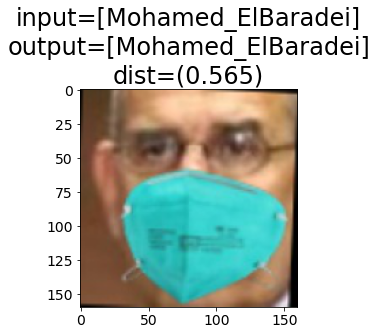

                  Dean_Barkley                 Gunter_Pleuger    0.61136


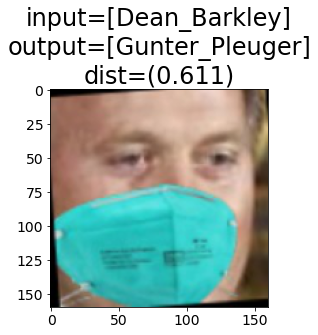

                    Tom_Reilly                     Tom_Reilly    0.64839


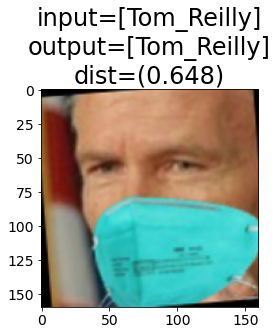

                   John_McCain                    John_McCain    0.47512


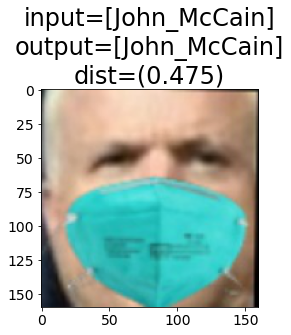

                Hootie_Johnson               Alejandro_Toledo    0.64269


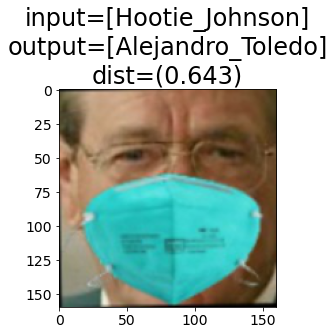

                Kim_Ryong-sung                 Kim_Ryong-sung    0.31675


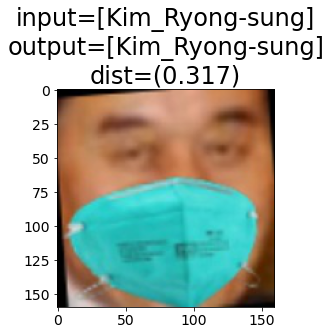

             Jennifer_Thompson                 Jacques_Chirac    0.62646


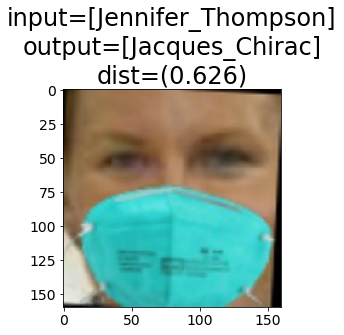

              Michelle_Collins               Michelle_Collins    0.41357


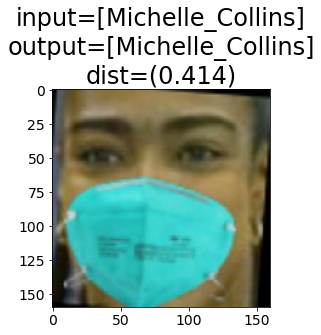

                    Gray_Davis                     Gray_Davis    0.65686


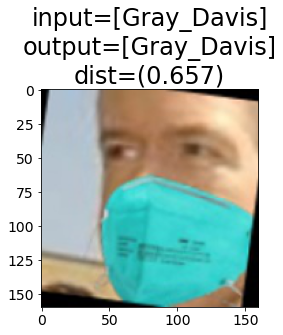

                   Matt_Dillon                 Robert_Mueller    0.62603


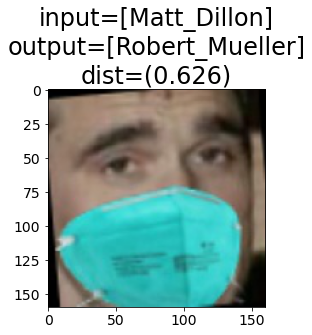

In [57]:
print("[INFO]: Predicting some samples from validation set...")
print("%30s %30s %10s" % ("input_label", "output_label", "distance"))
print("%30s %30s %10s" % ("===========", "============", "========"))
for i in range(0,10):
    emd = val_emd_norm_x[i]
    lbl = val_enc_y[i]
    prs = out_encoder.inverse_transform([lbl])

    print("%30s" % (prs[0]), end=" ")
    distances, indices = neighbors.kneighbors([emd])

    if ((indices is None) or (len(indices) <= 0)):
        print("NOT FOUND.")
        continue

    lbl_found = train_enc_y[indices[0][0]]
    prs_found = out_encoder.inverse_transform([lbl_found])[0]
    print("%30s %10.5f" % (prs_found, distances[0]))

    face = val_x[i]
    plt.imshow(face)
    title = 'input=[%s]\noutput=[%s]\ndist=(%.3f)' % (prs[0], prs_found, distances[0])
    plt.title(title)
    plt.show()
    

In [58]:
print("[INFO] Training NN model on unmasked training set...", end=" ")
len_masked          = train_masked_x.shape[0]
neighbors_unmasked  = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(train_emd_norm_x[len_masked:,])
print("DONE.")

[INFO] Training NN model on unmasked training set... DONE.


In [59]:
print("[INFO] Testing model on validation set (masked vs unmasked)...")
val_masked_len = val_masked_x.shape[0]
result_predict = prediction_utils.predict(neighbors_unmasked, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x[len_masked:,], train_enc_y[len_masked:,], val_emd_norm_x[:val_masked_len,], val_enc_y[:val_masked_len,])
print("DONE.")

[INFO] Testing model on validation set (masked vs unmasked)...
DONE.


In [60]:
print("Validation set performance (masked vs unmasked):")
prediction_utils.show_metrics(result_predict)

Validation set performance (masked vs unmasked):
    total:   1664 (100.00 %)
    TP:         1 (  0.06 %)
    FN:      1626 ( 97.72 %)
    FP:        37 (  2.22 %)
MALE:
    total:   1347 (100.00 %)
    TP:         1 (  0.07 %)
    FN:      1312 ( 97.40 %)
    FP:        34 (  2.52 %)
FEMALE:
    total:    317 (100.00 %)
    TP:         0 (  0.00 %)
    FN:       314 ( 99.05 %)
    FP:         3 (  0.95 %)
WHITE:
    total:   1508 (100.00 %)
    TP:         0 (  0.00 %)
    FN:      1477 ( 97.94 %)
    FP:        31 (  2.06 %)
ASIAN:
    total:     83 (100.00 %)
    TP:         1 (  1.20 %)
    FN:        77 ( 92.77 %)
    FP:         5 (  6.02 %)
BLACK:
    total:     73 (100.00 %)
    TP:         0 (  0.00 %)
    FN:        72 ( 98.63 %)
    FP:         1 (  1.37 %)


In [61]:
print("[INFO] Testing model on test set (masked vs unmasked)...")
test_masked_len = test_masked_x.shape[0]
result_predict = prediction_utils.predict(neighbors_unmasked, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x[len_masked:,], train_enc_y[len_masked:,], test_emd_norm_x[:test_masked_len,], test_enc_y[:test_masked_len,])
print("DONE.")

[INFO] Testing model on test set (masked vs unmasked)...
DONE.


In [62]:
print("Test set performance (masked vs unmasked):")
prediction_utils.show_metrics(result_predict)

Test set performance (masked vs unmasked):
    total:    887 (100.00 %)
    TP:         0 (  0.00 %)
    FN:       856 ( 96.51 %)
    FP:        31 (  3.49 %)
MALE:
    total:    717 (100.00 %)
    TP:         0 (  0.00 %)
    FN:       692 ( 96.51 %)
    FP:        25 (  3.49 %)
FEMALE:
    total:    170 (100.00 %)
    TP:         0 (  0.00 %)
    FN:       164 ( 96.47 %)
    FP:         6 (  3.53 %)
WHITE:
    total:    827 (100.00 %)
    TP:         0 (  0.00 %)
    FN:       806 ( 97.46 %)
    FP:        21 (  2.54 %)
ASIAN:
    total:     38 (100.00 %)
    TP:         0 (  0.00 %)
    FN:        29 ( 76.32 %)
    FP:         9 ( 23.68 %)
BLACK:
    total:     22 (100.00 %)
    TP:         0 (  0.00 %)
    FN:        21 ( 95.45 %)
    FP:         1 (  4.55 %)


In [63]:
time_end = datetime.datetime.now()
print(str(time_end))

time_diff = time_end - time_start
print("duration: ", time_diff)

2021-03-16 02:24:51.899428
duration:  0:45:21.997991
